In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np


In [2]:
data = pd.read_csv("diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [27]:
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values


In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:

X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [30]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [32]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [34]:

class DiabetesClassifier(nn.Module):
    def __init__(self):
        super(DiabetesClassifier, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DiabetesClassifier()

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
train_losses = []
test_accuracies = []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6932, Accuracy: 82.47%
Epoch 2/20, Loss: 0.6325, Accuracy: 81.82%
Epoch 3/20, Loss: 0.5742, Accuracy: 80.52%
Epoch 4/20, Loss: 0.5075, Accuracy: 81.82%
Epoch 5/20, Loss: 0.4892, Accuracy: 81.82%
Epoch 6/20, Loss: 0.4702, Accuracy: 82.47%
Epoch 7/20, Loss: 0.4739, Accuracy: 82.47%
Epoch 8/20, Loss: 0.4680, Accuracy: 81.17%
Epoch 9/20, Loss: 0.4635, Accuracy: 79.87%
Epoch 10/20, Loss: 0.4522, Accuracy: 79.87%
Epoch 11/20, Loss: 0.4539, Accuracy: 81.17%
Epoch 12/20, Loss: 0.4687, Accuracy: 79.87%
Epoch 13/20, Loss: 0.4694, Accuracy: 81.17%
Epoch 14/20, Loss: 0.4362, Accuracy: 79.87%
Epoch 15/20, Loss: 0.4541, Accuracy: 81.82%
Epoch 16/20, Loss: 0.4414, Accuracy: 79.22%
Epoch 17/20, Loss: 0.4350, Accuracy: 79.87%
Epoch 18/20, Loss: 0.4195, Accuracy: 81.17%
Epoch 19/20, Loss: 0.4167, Accuracy: 80.52%
Epoch 20/20, Loss: 0.4130, Accuracy: 80.52%
Training complete.


In [38]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_labels, all_predictions)

f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[94 13]
 [17 30]]
F1 Score: 0.80
Precision: 0.80
Recall: 0.81
Specificity: 0.76


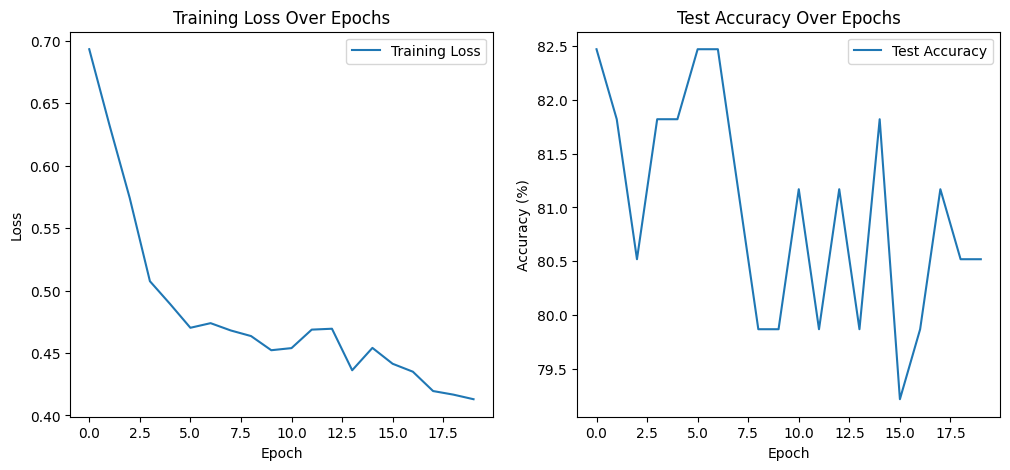

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()